In [8]:
PATH = '../data/query_test.csv'
X_MIN = -40.98
X_MAX = -12.983
Y_MIN = -79.805
Y_MAX = -62.402

In [10]:
(X_MAX - X_MIN) / (Y_MAX - Y_MIN)

1.6087456185715099

Import

In [3]:
import pandas as pd

query = pd.read_csv(PATH)
query.head(3)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-09-13T12:52:26.803Z,-24.1558,-66.8587,174.236,4.5,mb,94,54,1.704,1.26,...,2025-09-13T13:10:30.040Z,"55 km W of San Antonio de los Cobres, Argentina",earthquake,7.15,6.105,0.057,92,reviewed,us,us
1,2025-09-13T11:49:36.358Z,-17.6904,-65.8984,10.000,4.6,mb,25,87,1.943,0.90,...,2025-09-13T14:28:23.040Z,"11 km SSE of Cliza, Bolivia",earthquake,7.19,1.933,0.136,18,reviewed,us,us
2,2025-09-13T11:16:57.749Z,-24.1806,-67.0700,179.787,4.0,mb,67,63,1.591,0.98,...,2025-09-13T12:21:44.040Z,"76 km W of San Antonio de los Cobres, Argentina",earthquake,8.38,4.679,0.081,41,reviewed,us,us


filter

In [4]:
query['time'] = pd.to_numeric(pd.to_datetime(query["time"]))[0] / 10**9 # ns to s
query = query[['longitude', 'latitude', 'depth', 'time', 'mag']]
query.columns = ['x', 'y', 'z', 't', 'm']
query

,x,y,z,t,m
0,-66.8587,-24.1558,174.236,1.757768e+09,4.5
1,-65.8984,-17.6904,10.000,1.757768e+09,4.6
2,-67.0700,-24.1806,179.787,1.757768e+09,4.0
3,-67.0219,-24.2635,186.192,1.757768e+09,4.5
4,-67.1512,-23.9994,188.646,1.757768e+09,4.6
5,-66.6606,-22.9400,222.200,1.757768e+09,4.5
6,-69.3557,-17.8718,158.015,1.757768e+09,4.4
7,-68.5493,-21.5741,136.006,1.757768e+09,4.0
8,-66.7833,-19.4590,259.049,1.757768e+09,4.3
9,-67.1608,-24.3117,169.452,1.757768e+09,4.5


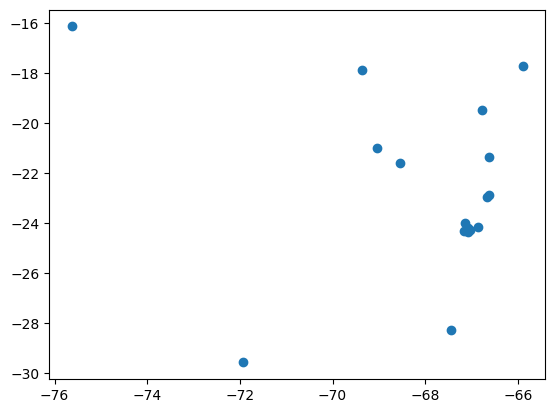

In [5]:
import matplotlib.pyplot as plt
plt.scatter(query['x'], query['y'])

circular mask

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('../data/query_test_200_200_2.csv')
data.head()

,x,y,z,t,m,idx_rad,idx_time
0,-67.1608,-24.3117,169.452,82.251323,4.5,0,0
1,-67.0833,-24.3345,163.360,20.870768,4.5,0,0
2,-66.6299,-22.8683,239.857,0.000000,4.2,0,0
3,-67.1608,-24.3117,169.452,82.251323,4.5,1,0
4,-66.6289,-21.3372,221.643,77.720192,4.9,1,0


In [3]:
data_t = data[['x', 'y', 'idx_time']]
data_t = data_t.drop_duplicates()
data_t

,x,y,idx_time
0,-67.1608,-24.3117,0
1,-67.0833,-24.3345,0
2,-66.6299,-22.8683,0
4,-66.6289,-21.3372,0
25,-69.0382,-20.9853,0
152,-67.0700,-24.1806,1
153,-67.0219,-24.2635,1
154,-67.1512,-23.9994,1
155,-65.8984,-17.6904,1
156,-69.3557,-17.8718,1


In [4]:
len(data['idx_rad'].unique())

73

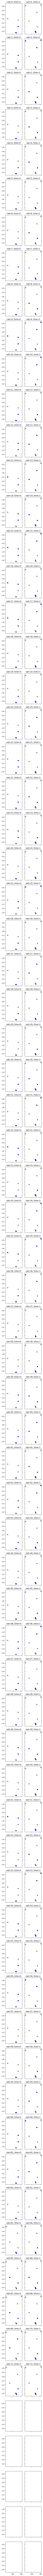

In [ ]:
grouped = data.groupby(['idx_rad', 'idx_time'])

ncols = len(data['idx_time'].unique()) # 2
nrows = len(data['idx_rad'].unique()) # 73

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols,2*nrows*1.6), sharey=True, sharex=True)

for (key, group), ax in zip(grouped, axes.flatten()):
    ax.scatter(data_t[data_t['idx_time'] == key[1]]['x'], data_t[data_t['idx_time'] == key[1]]['y'], c='k', alpha=0.5)
    ax.scatter(group['x'], group['y'], c='blue')
    ax.set_title(f"rad={key[0]}, time={key[1]}")
plt.scatter
plt.tight_layout()
plt.show()